In [1]:
from _01_mnist_example import x_train, x_test, y_train, y_test
from _01_mnist_example import y_train_5, y_test_5
from _01_mnist_example import sgd_clf

# 다수의 이중 분류기를 활용한 다중 분류기
**SGD, 랜덤포레스트, 나이브 베이즈**같은 일부 알고리즘은 자체적으로 여러 개의 클래스를 분류할 수 있음  
하지만 **로지스틱 회귀, 서포트 벡터 머신**같은 알고리즘은 이진 분류만 가능함  
이진 분류기를 여러 개 사용해서 다중 클래스를 분류하는 기법도 많음  
> **OvR(one versus the rest)**  
예를 들어 특정 숫자 하나만 구분하는 숫자별 이진 분류기를 10개 훈련시켜서  
결정 점수가 가장 높은 것의 클래스로 선택하는 방법  
클래스가 N개라면 필요한 분류기의 갯수는 **N**  
  
> **OvO(one versus one)**  
0과 1, 0과 2, 1과 2 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시켜서  
모든 분류기에 통과시킨 후 가장 많이 양성으로 분류된 클래스를 선택하는 방법  
클래스가 N개라면 필요한 분류기의 갯수는 **N x (N-1) / 2** : N개의 클래스에서 2개씩 뽑는 조합의 수  

일부 알고리즘(서포트 벡터 머신)은 학습 데이터셋의 크기에 민감해서  
큰 훈련 셋에서 적은 분류기를 훈련시키는 것보다 작은 훈련 셋에서 많은 분류기를 훈련시키는 쪽이 더 빠르다고 함  
이럴 땐 OvO 선호, 하지만 대부분의 이진 분류기는 OvR선호

In [2]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(x_train, y_train)

SVC()

이진 분류기를 다중 분류에 사용할 때 사이킷런이 알고리즘에 따라 알아서 OvO, OvR중 하나를 실행  
여기선 서포트 벡터 머신을 테스트하겠음

In [4]:
some_digit = x_train.iloc[0].to_numpy()
svm_clf.predict([some_digit])

array([5], dtype=uint64)

In [5]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

결정 점수를 확인, 제대로 5를 분류함

In [8]:
import numpy as np
max_score_idx = np.argmax(some_digit_scores)
svm_clf.classes_[max_score_idx], svm_clf.classes_

(5, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint64))

분류기가 훈련될 때 **classes_** 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장함

---  
사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 **OneVsClassifier**나 **OneVsRestClassifier**를 사용

In [9]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(x_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [10]:
print(ovr_clf.predict([some_digit]))
len(ovr_clf.estimators_)

[5]


10

사용 방법은 이진 분류기 인스턴스를 만들어 입력으로 전달하면 된다. (심지어 이진 분류기일 필요도 없단다)   

---
## SGD 분류기
SGD분류기는 직접 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvR, OvO를 적용할 필요가 없음  

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(x_train, y_train)

SGDClassifier()

In [15]:
sgd_clf.predict([some_digit]), sgd_clf.decision_function([some_digit])

(array([5], dtype=uint64),
 array([[-23432.27335326, -26256.61864449,  -8379.49813146,
          -2911.46492649, -17265.84746903,   3031.10902086,
         -28551.78965472,  -9691.46582936,  -7129.66720167,
         -10736.41985055]]))

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.8676 , 0.87785, 0.8788 ])

랜덤분류기를 사용했다면 10%정확도를 얻었을 것  
80%정도 수준으로 나쁘지 않음. 하지만 성능을 더 높일 여지가 있음  
예를 들어 **스케일링**만 해도 정확도를 높일 수 있음

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))

In [18]:
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

c:\users\gus8c\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([0.89935, 0.89265, 0.90535])

---
# 다중 분류기의 에러 분석
실제 프로젝트라면 머신러닝 프로젝트 체크리스트를 따라 데이터 준비 단계에서 가능한 선택 사항 탐색, 여러 모델 시도, 가장 좋은 몇 개를 골라 Gridsearch를 사용해 하이퍼파라미터 튜닝, 자동화 순으로 진행할 것  
여기선 그 중 가능성이 높은 모델을 하나 찾았다고 가정하고 그 모델의 성능을 향상 시킬 방법을 찾기 위해 **에러의 종류를 분석**하는 것을 다룸

In [19]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_train, y_train_pred)
conf_mat

array([[5698,    0,   38,   27,   13,   55,   29,    3,   49,   11],
       [   3, 6565,   39,   19,   13,   12,    6,   11,   61,   13],
       [ 133,  102, 4943,  233,   62,   43,   90,   81,  250,   21],
       [  88,   40,  154, 5297,   15,  185,   20,   72,  177,   83],
       [  40,   35,   35,   12, 5081,   21,   42,   77,  190,  309],
       [ 168,   50,   49,  292,  107, 4151,  116,   34,  386,   68],
       [ 134,   24,   62,   20,   44,   93, 5417,    8,  112,    4],
       [  32,   43,   69,   34,   52,   15,    4, 5732,   42,  242],
       [  87,  176,  111,  189,   50,  176,   55,   44, 4844,  119],
       [  50,   49,   23,   85,  276,   55,    3,  433,  141, 4834]],
      dtype=int64)

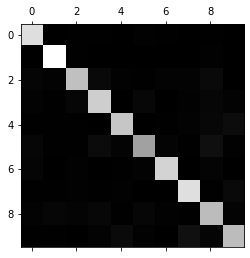

In [25]:
import matplotlib.pyplot as plt
plt.matshow(conf_mat, cmap=plt.cm.gray)
plt.show()

주대각 성분이 두드러지므로 성능은 나쁘지 않은 편임  
이렇게 단순 오차 행렬말고 다른 시각화도 보겠음

In [28]:
row_sums = conf_mat.sum(axis=1, keepdims=True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]], dtype=int64)

열마다 합계를 구함 : 학습한 분류기가 해당 클래스로 예측한 샘플의 수

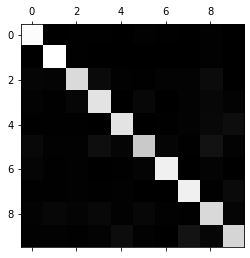

In [31]:
norm_conf_mat = conf_mat / row_sums
plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
plt.show()

기존 오차 행렬에 해당 값을 나눈 것은 해당 클래스로 예측한 샘플 중에서 맞추거나 틀린 비율을 보고자 함  
그런데 이 경우 정답을 맞춘 샘플이 월등히 많아 제대로 확인이 힘듦.  
따라서 주대각 성분을 0으로 채우고 다시 보겠음

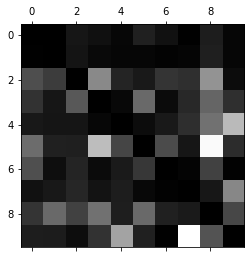

In [33]:
np.fill_diagonal(norm_conf_mat, 0)
plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
plt.show()

이제야 틀린 경우에 대한 비율을 제대로 확인 가능.  
두드러지는 부분은  
> 8클래스 열을 보면 대체로 다른 클래스를 8로 예측하는 경우가 많은 것을 볼 수 있음  
근데 8클래스 행을 보면 실제로 8인 값들은 그럭저럭 잘 맞춘다고 볼 수 있음

In [34]:
cl_a, cl_b = 3, 5
x_aa = x_train[(y_train==cl_a) & (y_train_pred==cl_a)]
x_ab = x_train[(y_train==cl_a) & (y_train_pred==cl_b)]
x_ba = x_train[(y_train==cl_b) & (y_train_pred==cl_a)]
x_bb = x_train[(y_train==cl_b) & (y_train_pred==cl_b)]

실제값과 예측값을 이용하여 잘 맞춘 샘플과 틀린 샘플을 추출하는 예시  
시각화를 통해 얼마나 비슷하길래 틀렸나 확인할 수 있음

In [58]:
import numpy as np

def plot_digits(df, row, col):
    for r in range(row):
        temp_row_digit = df.iloc[r*5].to_numpy()
        temp_row_img = temp_row_digit.reshape(28, 28)
        for c in range(1, col):
            idx = r*5 + c
            temp_digit = df.iloc[idx].to_numpy()
            temp_digit_img = temp_digit.reshape(28, 28)
            temp_row_img = np.append(temp_row_img, temp_digit_img, axis=1)
        if r == 0:
            img = temp_row_img
        else:
            img = np.append(img, temp_row_img, axis=0)
    plt.imshow(img, cmap=plt.cm.gray)

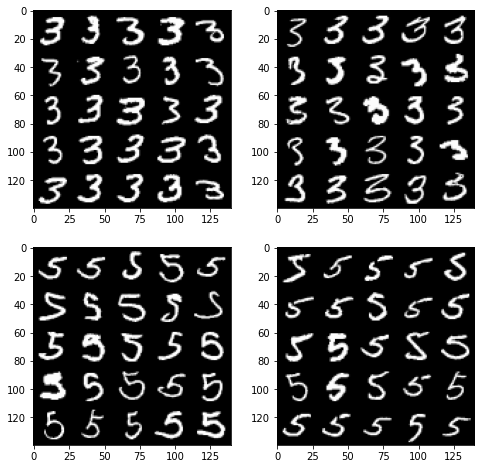

In [59]:
plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(x_aa[:25], 5, 5)
plt.subplot(222); plot_digits(x_ab[:25], 5, 5)
plt.subplot(223); plot_digits(x_ba[:25], 5, 5)
plt.subplot(224); plot_digits(x_bb[:25], 5, 5)

1,1 이미지는 3클래스라고 분류한 실제 3클래스 샘플 (정답)    
1,2 이미지는 5클래스라고 분류한 실제 3클래스 샘플 (오답)  
2,1 이미지는 3클래스라고 분류한 실제 5클래스 샘플 (오답)  
2,2 이미지는 5클래스라고 분류한 실제 5클래스 샘플 (정답)  

사람은 정답, 오답 샘플을 보고 직관으로 어떤 특징이 이 둘을 구분하고 모호하게 하는지 판단해야 함  
부각시켜야할 특징, 없애야할 특징을 찾았다면 전처리를 통해 이를 수정해야 함  
일단 학습한 모델이 SGD분류기라 각 픽셀에 가중치를 할당하는 방식이므로 그림의 회전, 위치에 영향을 많이 받음  
3과 5의 에러를 줄이는 방법의 예시로는  
> 이미지를 중앙에 위치  
회전되어 있지 않도록 전처리  
